In [ ]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

class CartPoleAgent:
    def __init__(self, env, learning_rate=0.01, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.995):
        self.env = env
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.exploration_min = 0.01
        self.numberOfActions = env.action_space.n
        self.memory = deque(maxlen=10000)
        self.Qnetwork = self.build_model()
        self.targetNetwork = self.build_model()
        self.update_target_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.env.observation_space.shape[0], activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.numberOfActions, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model
    
    def update_target_model(self):
        self.targetNetwork.set_weights(self.Qnetwork.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def action(self, state):
        if np.random.rand() < self.exploration_rate:
            return self.env.action_space.sample()
        state = np.reshape(state, [1, self.env.observation_space.shape[0]])
        q_values = self.Qnetwork.predict(state)
        return np.argmax(q_values[0])
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.reshape(state, [1, self.env.observation_space.shape[0]])
            next_state = np.reshape(next_state, [1, self.env.observation_space.shape[0]])
            target = reward
            if not done:
                target = (reward + self.discount_factor * np.amax(self.targetNetwork.predict(next_state)[0]))
            target_f = self.Qnetwork.predict(state)
            target_f[0][action] = target
            self.Qnetwork.fit(state, target_f, epochs=1, verbose=0)
        
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay
    
    def train(self, episodes, batch_size):
        episode_rewards = []  # To store total rewards per episode
        episode_steps = []    # To store steps per episode

        for e in range(episodes):
            state= self.env.reset()[0]
            state = np.reshape(state, [1, self.env.observation_space.shape[0]])
            total_reward = 0
            steps = 0
            while True:
                action = self.action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.env.observation_space.shape[0]])
                self.remember(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward
                steps += 1
                if done:
                    self.update_target_model()
                    episode_rewards.append(total_reward)
                    episode_steps.append(steps)
                    print(f"episode: {e}, score: {total_reward}, steps: {steps}")
                    break
                if len(self.memory) > batch_size:
                    self.replay(batch_size)
        
        # Save the model after training
        self.save_model()

        # Plotting
        self.plot_results(episode_rewards, episode_steps)

    def save_model(self):
        save_model(self.Qnetwork, 'cartpole_model.h5')

    def plot_results(self, episode_rewards, episode_steps):
        # Plot total rewards per episode
        plt.figure(figsize=(10, 5))
        plt.plot(episode_rewards, marker='o', linestyle='-', color='b')
        plt.title('Total Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.grid(True)
        plt.savefig('total_rewards.png')
        plt.show()

        # Plot steps per episode
        plt.figure(figsize=(10, 5))
        plt.plot(episode_steps, marker='o', linestyle='-', color='g')
        plt.title('Steps per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Steps')
        plt.grid(True)
        plt.savefig('steps_per_episode.png')
        plt.show()

if __name__ == "__main__":
    # Create the CartPole environment using gym
    env = gym.make('CartPole-v1')

    # Initialize the CartPole agent
    agent = CartPoleAgent(env)

    # Train the agent
    agent.train(episodes=300, batch_size=32)

    # After training, the model weights will be saved to 'cartpole_model.h5'
    # Plots will be saved as 'total_rewards.png' and 'steps_per_episode.png'


In [ ]:
import sys
import gymnasium as gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

EPISODES = 300


# 카트폴 예제에서의 DQN 에이전트
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False
        self.load_model = False

        # 상태와 행동의 크기 정의
        self.state_size = state_size
        self.action_size = action_size

        # DQN 하이퍼파라미터
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = self.build_model()
        self.target_model = self.build_model()

        # 타깃 모델 초기화
        self.update_target_model()

        if self.load_model:
            self.model.load_weights("./save_model/cartpole_dqn_trained.h5")

    # 상태가 입력, 큐함수가 출력인 인공신경망 생성
    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        #model.summary()
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    # 타깃 모델을 모델의 가중치로 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # 입실론 탐욕 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # 샘플 <s, a, r, s'>을 리플레이 메모리에 저장
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 리플레이 메모리에서 무작위로 추출한 배치로 모델 학습
    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        # 현재 상태에 대한 모델의 큐함수
        # 다음 상태에 대한 타깃 모델의 큐함수
        target = self.model.predict(states)
        target_val = self.target_model.predict(next_states)

        # 벨만 최적 방정식을 이용한 업데이트 타깃
        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (
                    np.amax(target_val[i]))

        self.model.fit(states, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)


if __name__ == "__main__":
    # CartPole-v1 환경, 최대 타임스텝 수가 500
    env = gym.make('CartPole-v1')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    # DQN 에이전트 생성
    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []

    for e in range(EPISODES):
        done = False
        score = 0
        # env 초기화
        state = env.reset()[0]
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            # 현재 상태로 행동을 선택
            action = agent.get_action(state)
            # 선택한 행동으로 환경에서 한 타임스텝 진행
            next_state, reward, done, info,_ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            # 에피소드가 중간에 끝나면 -100 보상
            reward = reward if not done or score == 499 else -100

            # 리플레이 메모리에 샘플 <s, a, r, s'> 저장
            agent.append_sample(state, action, reward, next_state, done)
            # 매 타임스텝마다 학습
            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            score += reward
            state = next_state

            if done:
                # 각 에피소드마다 타깃 모델을 모델의 가중치로 업데이트
                agent.update_target_model()

                score = score if score == 500 else score + 100
                # 에피소드마다 학습 결과 출력
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("E:\Reinforcmeent Code , Practics\Cart pole/cartpole_dqn.png")
                print("episode:", e, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)

                # 이전 10개 에피소드의 점수 평균이 490보다 크면 학습 중단
                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    agent.model.save_weights("E:\Reinforcmeent Code , Practics\Cart polecartpole_dqn.h5")
                    sys.exit()

In [ ]:
import sys
import gymnasium as gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False# Set render to True to enable environment rendering
        self.load_model = False  # Set load_model to True to load the trained weights

        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0  # Set epsilon to 0 to use the trained model for actions
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        self.memory = deque(maxlen=2000)

        self.model = self.build_model()
        self.target_model = self.build_model()

        self.update_target_model()

        if self.load_model:
            self.model.load_weights("E:\Reinforcmeent Code , Practics\Cart pole\cartpole_dqn.h5")

    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        q_value = self.model.predict(state)
        return np.argmax(q_value[0])

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        target = self.model.predict(states)
        target_val = self.target_model.predict(next_states)

        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (
                    np.amax(target_val[i]))

        self.model.fit(states, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)

if __name__ == "__main__":
    env = gym.make('CartPole-v1')  # Set render_mode to 'human'
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []
    EPISODES = 300  
    for e in range(EPISODES):
        done = False
        
        score = 0
        state = env.reset()[0]
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            action = agent.get_action(state)
            next_state, reward, done, info, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            reward = reward if not done or score == 499 else -100

            agent.append_sample(state, action, reward, next_state, done)
            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            score += reward
            state = next_state

            if done:
                agent.update_target_model()

                score = score if score == 500 else score + 100
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("E:/Reinforcmeent Code , Practics/Cart pole/cartpole_dqn.png")
                print("episode:", e, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)

                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    agent.model.save_weights("E:/Reinforcmeent Code , Practics/Cart pole/cartpole_new_dqn.h5")
                    sys.exit()


In [1]:
import sys
import gymnasium as gym
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
import pygame

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = 0.001

        self.model = self.build_model()
        self.model.load_weights("E:\Reinforcmeent Code , Practics\Cart pole\cartpole_new_dqn.h5")

    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def get_action(self, state):
        q_value = self.model.predict(state, verbose=0)
        return np.argmax(q_value[0])

def render_cartpole(agent, env):
    pygame.init()
    screen = pygame.display.set_mode((600, 400))
    pygame.display.set_caption("CartPole DQN Agent")
    clock = pygame.time.Clock()
    font = pygame.font.SysFont(None, 55)

    state = env.reset()[0]
    state = np.reshape(state, [1, state_size])
    done = False
    score = 0

    while not done:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()

        screen.fill((255, 255, 255))

        action = agent.get_action(state)
        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        score += reward
        state = next_state

        score_text = font.render(f"Score: {int(score)}", True, (0, 0, 0))
        screen.blit(score_text, (10, 10))

        pygame.display.flip()
        clock.tick(30)

        if done or score >= 2000:
            break

    print("Final score:", score)
    pygame.quit()

if __name__ == "__main__":
    env = gym.make('CartPole-v1', render_mode='human')
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)
    render_cartpole(agent, env)


c:\Users\admin\anaconda3\envs\malak1\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


SystemExit: 

c:\Users\admin\anaconda3\envs\malak1\lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


1/1 [==============================] - 0s 17ms/step


c:\Users\admin\anaconda3\envs\malak1\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 18ms/step
episode: 0   score: 9.0   memory length: 10   epsilon: 1.0
1/1 [==============================] - 0s 17ms/step
episode: 1   score: 9.0   memory length: 20   epsilon: 1.0
1/1 [==============================] - 0s 11ms/step
episode: 2   score: 7.0   memory length: 28   epsilon: 1.0
1/1 [==============================] - 0s 19ms/step
episode: 3   score: 9.0   memory length: 38   epsilon: 1.0
1/1 [==============================] - 0s 15ms/step
episode: 4   score: 9.0   memory length: 48   epsilon: 1.0
1/1 [==============================] - 0s 17ms/step
episode: 5   score: 9.0   memory length: 58   epsilon: 1.0
1/1 [==============================] - 0s 17ms/step
episode: 6   score: 7.0   memory length: 66   epsilon: 1.0
1/1 [==============================] - 0s 15ms/step
episode: 7   score: 9.0   memory length: 76   epsilon: 1.0
1/1 [==============================] - 0s 16ms/step
episode: 8   score: 9.0   memory length: 86   epsilon: 1.0
1

SystemExit: 

c:\Users\admin\anaconda3\envs\malak1\lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


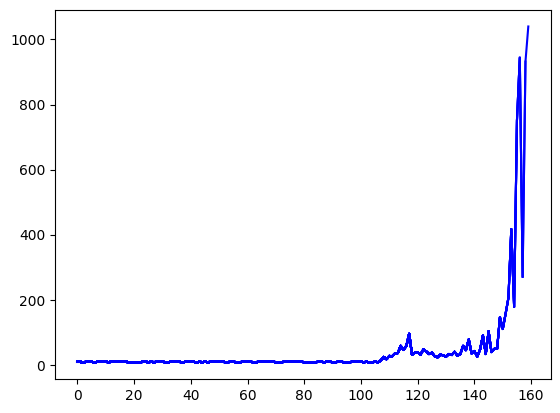

In [6]:
import sys
import gymnasium as gym
import pylab
import random
import numpy as np
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.render = False# Set render to True to enable environment rendering
        self.load_model = False  # Set load_model to True to load the trained weights

        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0  # Set epsilon to 0 to use the trained model for actions
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        self.memory = deque(maxlen=2000)

        self.model = self.build_model()
        self.target_model = self.build_model()

        self.update_target_model()

        if self.load_model:
            self.model.load_weights("E:\Reinforcmeent Code , Practics\Cart pole\cartpole_dqn.h5")

    def build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(24, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        q_value = self.model.predict(state)
        return np.argmax(q_value[0])

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.zeros((self.batch_size, self.state_size))
        next_states = np.zeros((self.batch_size, self.state_size))
        actions, rewards, dones = [], [], []

        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            actions.append(mini_batch[i][1])
            rewards.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            dones.append(mini_batch[i][4])

        target = self.model.predict(states)
        target_val = self.target_model.predict(next_states)

        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.discount_factor * (
                    np.amax(target_val[i]))

        self.model.fit(states, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)

if __name__ == "__main__":
    env = gym.make('CartPole-v1')  # Set render_mode to 'human'
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    scores, episodes = [], []
    EPISODES = 300  
    for e in range(EPISODES):
        done = False
        
        score = 0
        state = env.reset()[0]
        state = np.reshape(state, [1, state_size])

        while not done:
            if agent.render:
                env.render()

            action = agent.get_action(state)
            next_state, reward, done, info, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            reward = reward if not done or score == 499 else -100

            agent.append_sample(state, action, reward, next_state, done)
            if len(agent.memory) >= agent.train_start:
                agent.train_model()

            score += reward
            state = next_state

            if done:
                agent.update_target_model()

                score = score if score == 500 else score + 100
                scores.append(score)
                episodes.append(e)
                pylab.plot(episodes, scores, 'b')
                pylab.savefig("E:/Reinforcmeent Code , Practics/Cart pole/cartpole_dqn.png")
                print("episode:", e, "  score:", score, "  memory length:",
                      len(agent.memory), "  epsilon:", agent.epsilon)

                if np.mean(scores[-min(10, len(scores)):]) > 490:
                    #agent.model.save_weights("/content/Resultse/cartpole_new_dqn.h5")
                    sys.exit()
